In [1]:
import geone
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
from geone import imgplot3d
import pyvista as pv

sys.path.append("../../../../Thèse/prog et code/geostat/EROS/")
sys.path.append("../../")
import EROS

In [2]:
def surfs_int(alt, covs, top, bot):
    
    sims = []
    for i in range(len(alt)):

        sim = geone.multiGaussian.multiGaussianRun(covs[i], nx, sx, output_mode="array", mean=alt[i])[0]
        sim[sim > top] = top[sim > top]
        sim[sim < bot] = bot[sim < bot]

        for o in range(i):  # erosion rules
            s2 = sims[o]  # older surface

            mask = s2 > sim
            s2[mask] = sim[mask]
        sims.append(sim)
    
    return sims

In [3]:
# from merge_two_covmodels import * 

In [4]:
with open("cm_params_NS.pkl", "rb") as f:
    ns = pickle.load(f)
    
with open("cm_params_EW.pkl", "rb") as f:
    ew = pickle.load(f)

In [5]:
ew[4]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 0.047233523810471016
        r = 43.5747063045942
elementary contribution 1
    type: cubic
    parameters:
        w = 0.40880454871251315
        r = 44.36080345389514
elementary contribution 2
    type: exponential
    parameters:
        w = 0.00213663722280625
        r = 41.58781461836194
*****

In [6]:
ns[3]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 2
elementary contribution 0
    type: cubic
    parameters:
        w = 0.2680875736151002
        r = 15.979741526540924
elementary contribution 1
    type: cubic
    parameters:
        w = 0.3885146722456591
        r = 29.901044125263223
*****

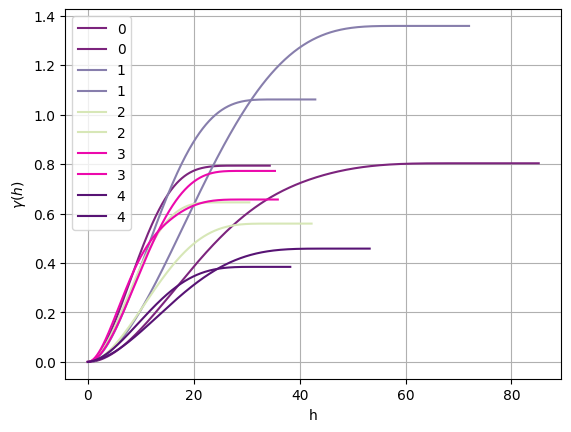

In [7]:
for i_group in range(5):
    
    color = np.random.random(3)
    ns[i_group].plot_model(1, c=color, label=i_group)
    ew[i_group].plot_model(1, c=color, label=i_group)
    
    plt.legend()

In [8]:
ns[i_group]

*** CovModel1D object ***
name = 'cov1D-multi-contribution'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 0.033998096609768054
        r = 30.280577219182565
elementary contribution 1
    type: cubic
    parameters:
        w = 0.34863220117967847
        r = 31.863577222821558
elementary contribution 2
    type: exponential
    parameters:
        w = 0.00167676605583729
        r = 22.97360036812227
*****

In [9]:
def merge_covmodels(cm1, cm2):
    
    elem = []
    for cov_type in ("spherical", "cubic", "exponential", "gaussian", "nugget", "power"):

        elem_i = []
        for cm in (cm1, cm2):
            for e in cm.elem:
                if e[0] == cov_type:
                    elem_i.append(e)
                    break
        
        if len(elem_i) == 0:
            pass
        elif len(elem_i) == 1:
            ran = [elem_i[0][1]["r"], elem_i[0][1]["r"]]
            elem.append((cov_type, {"w": elem_i[0][1]["w"], "r":ran}))
        else:
            if cov_type == "nugget":
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2}))
            else:
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2,
                                        "r": [elem_i[0][1]["r"], elem_i[1][1]["r"]]}))
    
    cm = geone.covModel.CovModel2D(elem = elem)
    
    return cm

In [10]:
# merge covariances
cm_merged_list = []
for igroup in range(5):

    cm_ns = ns[igroup]
    cm_ew = ew[igroup]
    
    elem = []
    for cov_type in ("spherical", "cubic", "exponential", "gaussian", "nugget", "power"):

        elem_i = []
        for cm in (cm_ew, cm_ns):
            for e in cm.elem:
                if e[0] == cov_type:
                    elem_i.append(e)
                    break
        
        if len(elem_i) == 0:
            pass
        elif len(elem_i) == 1:
            ran = [elem_i[0][1]["r"], elem_i[0][1]["r"]]
            elem.append((cov_type, {"w": elem_i[0][1]["w"], "r":ran}))
        else:
            if cov_type == "nugget":
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2}))
            else:
                elem.append((cov_type, {"w": (elem_i[0][1]["w"] + elem_i[1][1]["w"]) / 2,
                                        "r": [elem_i[0][1]["r"], elem_i[1][1]["r"]]}))
    
    cm = geone.covModel.CovModel2D(elem = elem)
    cm_merged_list.append(cm)

In [11]:
# np.random.seed(64)
# cm_merged_list = []
# for igroup in range(5):

#     cm_ns = ns[igroup]
#     cm_ew = ew[igroup]

#     cm_merged = merge_two_covmodels(cm_ns, cm_ew)
#     color = np.random.random(3)
#     cm_merged.plot_model(color=color)
#     cm_ns.plot_model(linestyle="--", color=color)
#     cm_ew.plot_model(linestyle="--", color=color)
    
#     cm_merged_list.append(cm_merged)

In [12]:
# EW

#probas
proba1 = (0.10, 0.15, 0.1, 0.70)  # blue, brown, green, yellow
proba2 = (0.08, 0, 0.12, 0.8)
proba3 = (0.05, 0, 0.22, 0.73)
proba4 = (0, 0.10, 0.5, 0.4)
proba5 = (0, 0, 0.1, 0.9)
probas_ew = [proba1, proba2, proba3, proba4, proba5]

#N
N_ew = [20, 15, 10, 10, 3]

# alts
alt_ew = [3.9, 5.75, 8.23, 10.59]

#covs
cm_r5_ew = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.12, "r":25}),
                                              ("cubic", {"w":0.15, "r":60})])
cm_r4_ew = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.25, "r":90})])

#NS
# probas
proba1 = (0, 0.1, 0.5, 0.4)
proba2 = (0, 0.31, 0.32, 0.37)
proba3 = (0, 0.35, 0.2, 0.45)
proba4 = (0, 0.45, 0, 0.45)
proba5 = (0, 0, 0, 1)
probas_ns = [proba1, proba2, proba3, proba4, proba5]

#N
N_ns = [10, 15, 10, 20, 3]

#covs
cm_r5_ns = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.65, "r":68}),
                                              ("cubic", {"w":0.1, "r":30})])

cm_r4_ns = geone.covModel.CovModel1D(elem = [("cubic", {"w":0.26, "r":90}),
                                              ("spherical", {"w":0., "r":80})])

# alts
alt_ns = [4.43, 7.22, 10.99, 13.68]

## merge everything

#facies ids
facies_ids = [1, 2, 3, 4]

# Mean probas --> blue, brown, green, yellow
proba1 = np.array((probas_ew[0][0] + probas_ns[0][1], probas_ew[0][1] + 0, probas_ew[0][2] + \
          probas_ns[0][0], probas_ew[0][3] + probas_ns[0][2]))
proba1 /= proba1.sum()

proba2 = np.array((probas_ew[1][0] + probas_ns[1][1], probas_ew[1][1] + 0, probas_ew[1][2] + \
          probas_ns[1][0], probas_ew[1][3] + probas_ns[1][2]))
proba2 /= proba2.sum()

proba3 = np.array((probas_ew[2][0] + probas_ns[2][1], probas_ew[2][1] + 0, probas_ew[2][2] + \
          probas_ns[2][0], probas_ew[2][3] + probas_ns[2][2]))
proba3 /= proba3.sum()

proba4 = np.array((probas_ew[3][0] + probas_ns[3][1], probas_ew[3][1] + 0, probas_ew[3][2] + \
          probas_ns[3][0], probas_ew[3][3] + probas_ns[3][2]))
proba4 /= proba4.sum()

proba5 = np.array((probas_ew[4][0] + probas_ns[4][1], probas_ew[4][1] + 0, probas_ew[4][2] + \
          probas_ns[4][0], probas_ew[4][3] + probas_ns[4][2]))
proba5 /= proba5.sum()

probas = [proba1, proba2, proba3, proba4, proba5]

# colors of each facies
colors = np.array(([0.4, 0.6, 1. , 1. ], 
                  [0.6, 0.2, 0. , 1. ],
                  [0.2, 0.6, 0. , 1. ],
                  [1. , 0.8, 0.2, 1. ]))
                 
# N
N = np.mean(np.array((N_ew, N_ns)), 0)  # number of surfaces

# alts
alts = np.mean(np.array((alt_ew, alt_ns)), 0)  # number of surfaces

# covs
cm_r5 = merge_covmodels(cm_r5_ew, cm_r5_ns)
cm_r4 = merge_covmodels(cm_r4_ew, cm_r4_ns)
covs = [cm_r4, cm_r5, cm_r4, cm_r4]

### Functions

In [13]:
def surfs_int(alt, covs, top, bot, dim, spa):
    
    sims = []
    for i in range(len(alt)):

        sim = geone.multiGaussian.multiGaussianRun(covs[i], dim, spa, output_mode="array", mean=alt[i], use_multiprocessing=False)[0]
        sim[sim > top] = top[sim > top]
        sim[sim < bot] = bot[sim < bot]

        for o in range(i):  # erosion rules
            s2 = sims[o]  # older surface

            mask = s2 > sim
            s2[mask] = sim[mask]
        sims.append(sim)
    
    return sims

In [14]:
def proto_HEROS_3D(ngroups, covmodel_by_groups, proba_by_groups, facies_ids,
                N_by_group, alpha_by_group, xi_by_group,  # EROS params by group
                top, bot, alt, covs,  # intermediate surface params
                dim, spa, ori,  # grid parameters
                nreal=1, seed=None, verbose=1,
                 ):
    
    np.random.seed(seed)  # set seed

    all_surfs = []
    all_sims = []
    all_high_surfs = []
    mask_by_group = []
    
    for ireal in range(nreal):
        
        if verbose:
            print("sims {}".format(ireal))

        high_surfs = surfs_int(alt, covs, top, bot, (dim[0], dim[1]), (spa[0], spa[1]))  # simulate intermediate levels
        
        surfs = []
        arr_final = np.zeros([nz, ny, nx], dtype=int)
        
        for i in range(ngroups):

            seed = np.random.randint(1e6)

            # EROS params
            if hasattr(N_by_group, "__iter__"):
                N_i = int(N_by_group[i])
            else:
                N_i = int(N_by_group)
                
            if hasattr(proba_by_groups, "__iter__"):
                proba_i = proba_by_groups[i]
            else:
                proba_i = proba_by_groups

            if hasattr(covmodel_by_groups, "__iter__"):
                covmodel_i = covmodel_by_groups[i]
            else:
                covmodel_i = covmodel_by_groups

            if hasattr(alpha_by_group, "__iter__"):
                alpha_i = alpha_by_group[i]
            else:
                alpha_i = alpha_by_group
                
            if hasattr(xi_by_group, "__iter__"):
                xi_i = xi_by_group[i]
            else:
                xi_i = xi_by_group

            ## intermediate bot/top    
            if i > 0:
                bot_int = high_surfs[i-1]
                min_v = alt[i-1]
            else:
                bot_int = bot
                min_v = np.min(bot)

            if i < len(probas) - 1:
                top_int = high_surfs[i]
                max_v = alt[i]
            else:
                top_int = top
                max_v = np.max(top)

        #     top_int[top_int < bot_int] = bot_int[top_int < bot_int]
            height = max_v - min_v

            #means = np.sort(np.random.uniform(min_v - 0.1 * height, max_v + 0.1 * height, size=N_i))
            means = np.linspace(min_v - 0.1 * height, max_v + 0.1 * height, N_i)
            
#             print(means, bot_int, top_int)
            arr_res, real_surf = EROS.sim_uncond_3D(N_i, covmodel_i, means,
                                                                 dim, spa, ori,
                                                                 bot = bot_int, top = top_int, xi = xi_i,
                                                                 proba_cdf=proba_i, facies_ids = facies_ids,
                                                                 alpha=alpha_i, seed=seed, verbose=verbose)
            
            
            arr_final[arr_res != -99] = arr_res[arr_res != -99]
            surfs.append(real_surf)
            
            mask_by_group.append(arr_res > 0)
            
        arr_final[arr_final==0] = -99  # set unknown values to -99
        surfs = np.concatenate(surfs)  # concatenate the surfaces
        
        all_surfs.append(surfs)
        all_sims.append(arr_final)
        all_high_surfs.append(high_surfs)
        
    return np.array(all_sims), np.array(all_surfs), all_high_surfs, mask_by_group

In [15]:
oz = 0
z1 = 14
ox = 0
x1 = 170
oy = 0
y1 = 170
nx = 200
ny = 200
nz = 100
sx = x1 / nx
sy = y1 / ny
sz = z1 / nz
xg = np.linspace(0, x1, nx)
yg = np.linspace(0, y1, ny)
zg = np.linspace(0, z1, nz)

top = np.ones([ny, nx]) * z1
bot = np.ones([ny, nx]) * oz

In [16]:
%%time
sims, surfs, high_surfs, masks = proto_HEROS_3D(5, cm_merged_list, probas, facies_ids,
                                          N, 0.8, 0.2,
                                          top=top, bot=bot,
                                          alt=alts, covs=covs,
                                          dim=(nx, ny, nz), spa=(sx, sy, sz), ori=(ox, oy, oz),
                                          nreal=30, seed=20, verbose=1)

sims 0
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.48 s
Discretization : time elapsed 1.39 s
Assign facies : time elapsed 0.96 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 1.98 s
Discretization : time elapsed 1.57 s
Assign facies : time elapsed 1.55 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 1.23 s
Discretization : time elapsed 0.96 s
Assign facies : time elapsed 0.64 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.57 s
Discretization : time elapsed 3.08 s
Assign facies : time elapsed 3.13 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 0.36 s
Discretization : time elapsed 0.58 s
Assign facies : time elapsed 0.25 s
sims 1
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.1 s
Discretization : time elapsed 1.42 s
Assign facies : time elapsed 1.11 s
setup phase : time elapsed 0.0 s
Compute surfaces : time elapsed 2.24 s
Discretization : time elapsed 1.62 s
Assign f

In [17]:
nz

100

In [18]:
import flopy

workspace = "working"
name = "EROS_eq_perm"
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="../../../../Thèse/prog et code/modfow/exe/win64/mf6.exe", version="mf6", sim_ws=workspace
)
"../"
# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="complex", outer_dvclose=5e-2, inner_dvclose=5e-3)

botm = np.linspace(oz / nz, z1 - sz, nz)
delrow = sx
delcol = sy
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nz,
    nrow=ny,
    ncol=nx,
    delr=delrow,
    delc=delcol,
    top=z1,
    botm=botm[::-1],
)

headfile = f"{name}.hds"
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("BUDGET", "ALL")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [19]:
dic_facies_k = {3:  1e-1,
                1: 1e-4, 
                2: 1e-2, 
                4: 1e-5}

K = sims[0].copy().astype(float)
K[sims[0] == -99] = 1e-30

for key, value in dic_facies_k.items():
    K[K == key] = value

In [20]:
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=0, k= K,
    save_flows=True, save_specific_discharge=True 
)

    # write the changes to the npf file
# npf.write()  

In [21]:
# BCs
chd_rec = []
L = sim.get_model().dis.delc[0] * sim.get_model().dis.nrow.array

# face x-z
for i in range(nx):
    for iz in range(nz):
        chd_rec.append(((iz, 0, i), L))
        chd_rec.append(((iz, ny-1, i), 0))

# face y-z
grad_y = np.linspace(L, 0, ny)
for i in range(1, ny-1):
    for iz in range(1, nz-1):
        chd_rec.append(((iz, i, 0),  grad_y[i]))
        chd_rec.append(((iz, i, nx-1), grad_y[i]))

# face x-y
for i in range(1, nx-1):
    for j in range(1, ny-1):
        chd_rec.append(((0, j, i), grad_y[j]))
        chd_rec.append(((nz-1, j, i), grad_y[j]))

chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
    )

# chd.write()

# initial conditions
a = np.ones((ny, nx)) * grad_y
start = np.zeros((nz, ny, nx))
start[:, :, :] = a.T

ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)
# ic.write()

# run the model
sim.write_simulation()
# sim.run_simulation()

# get specific discharge
# spd = flopy.utils.CellBudgetFile(os.path.join(workspace, f"{name}.cbb"), precision="double").get_data(text="DATA-SPDIS")

# get mean discharge in x, y, z
# qx2 = spd[0]["qx"].mean()
# qy2 = spd[0]["qy"].mean()  
# qz2 = spd[0]["qz"].mean()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EROS_eq_perm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package npf...
    writing package chd...
    writing package ic...


In [22]:
import flopy

In [23]:
import parallel

In [24]:
l_keq = parallel.parallel_compute(sims, dic_facies_k, 10, nx, ny, nz)

In [25]:
l_keq

[array([[ 7.92343704e-03, -6.34194675e-05,  8.12040695e-06],
        [-6.57385998e-05,  5.74296857e-03,  1.97575915e-05],
        [ 5.26381948e-07,  3.25082574e-05,  3.61533933e-04]]),
 array([[ 7.98663524e-03, -2.39591434e-04, -1.62800581e-06],
        [-2.40670950e-04,  5.51300511e-03, -9.75949768e-07],
        [ 1.96435608e-06, -1.11765704e-05,  2.55115295e-04]]),
 array([[ 1.35014401e-02, -6.13096617e-05, -4.74496784e-05],
        [-6.24432874e-05,  1.07492494e-02,  1.46839463e-05],
        [-3.88383964e-05,  1.41010535e-05,  4.92078525e-04]]),
 array([[ 5.86175760e-03, -8.88224016e-05,  5.16178465e-06],
        [-8.71836561e-05,  4.28594115e-03,  2.64811150e-05],
        [ 7.56698962e-06,  2.61977528e-05,  2.81251117e-04]]),
 array([[ 7.68138602e-03,  5.52246586e-04, -3.79999198e-06],
        [ 5.52126231e-04,  5.51477432e-03, -1.85392950e-05],
        [-3.58530199e-06, -1.85634887e-05,  3.56998416e-04]]),
 array([[ 1.16328732e-02,  4.75318736e-06, -2.89733408e-06],
        [ 3.77

In [23]:
def compute_k_eq(k, model_ws="working", modelname="EROS_eq_perm", k22=None, k33=None, angle1=None, angle2=None, angle3=None):

    # model_ws = "working"
    # modelname = "EROS_eq_perm"

    sim = flopy.mf6.MFSimulation.load(sim_ws=model_ws, sim_name=modelname, verbosity_level=0,
                                      exe_name="../../../../Thèse/prog et code/modfow/exe/win64/mf6.exe")  # load the simulation

    gwf = sim.get_model()

    if angle1 is not None or angle2 is not None or angle3 is not None:
        xt3d = True
    else:
        xt3d = False

    npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf, pname="npf", icelltype=0, k=k, k22=k22, k33=k33, 
        angle1=angle1, angle2=angle2, angle3=angle3, xt3doptions=xt3d, 
        save_flows=True, save_specific_discharge=True 
    )

        # write the changes to the npf file
    npf.write()  

    ### computing discharge

    ## Y direction

    # BCs
    chd_rec = []
    L = sim.get_model().dis.delc[0] * sim.get_model().dis.nrow.array

    # face x-z
    for i in range(nx):
        for iz in range(nz):
            chd_rec.append(((iz, 0, i), L))
            chd_rec.append(((iz, ny-1, i), 0))

    # face y-z
    grad_y = np.linspace(L, 0, ny)
    for i in range(1, ny-1):
        for iz in range(1, nz-1):
            chd_rec.append(((iz, i, 0),  grad_y[i]))
            chd_rec.append(((iz, i, nx-1), grad_y[i]))

    # face x-y
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            chd_rec.append(((0, j, i), grad_y[j]))
            chd_rec.append(((nz-1, j, i), grad_y[j]))

    chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        pname="chd",
        maxbound=len(chd_rec),
        stress_period_data=chd_rec,
        save_flows=True,
        )

    chd.write()

    # initial conditions
    a = np.ones((ny, nx)) * grad_y
    start = np.zeros((nz, ny, nx))
    start[:, :, :] = a.T

    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)
    ic.write()

    # run the model
    sim.run_simulation()

    # get specific discharge
    spd = flopy.utils.CellBudgetFile(os.path.join(model_ws, f"{modelname}.cbb"), precision="double").get_data(text="DATA-SPDIS")

    # get mean discharge in x, y, z
    qx2 = spd[0]["qx"].mean()
    qy2 = spd[0]["qy"].mean()  
    qz2 = spd[0]["qz"].mean()

    # print(qx2, qy2, qz2)
    
    ## X direction

    # BCs
    chd_rec = []
    L = sim.get_model().dis.delr[0] * sim.get_model().dis.ncol.array

    # face y-z
    for i in range(ny):
        for iz in range(nz):
            chd_rec.append(((iz, i, 0), 0))
            chd_rec.append(((iz, i, nx-1), L))

    # face x-z
    grad_x = np.linspace(0, L, nx)
    for i in range(1, nx-1):
        for iz in range(1, nz-1):
            chd_rec.append(((iz, 0, i),  grad_x[i]))
            chd_rec.append(((iz, ny-1, i), grad_x[i]))

    # face x-y
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            chd_rec.append(((0, i, j), grad_x[j]))
            chd_rec.append(((nz-1, i, j), grad_x[j]))

    chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        pname="chd",
        maxbound=len(chd_rec),
        stress_period_data=chd_rec,
        save_flows=True,
        )

    chd.write()

    # initial conditions
    a = np.ones((ny, nx)) * grad_x
    start = np.zeros((nz, ny, nx))
    start[:, :, :] = a

    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)
    ic.write()

    # run the model
    sim.run_simulation()

    # get specific discharge
    spd = flopy.utils.CellBudgetFile(os.path.join(model_ws, f"{modelname}.cbb"), precision="double").get_data(text="DATA-SPDIS")

    # get mean discharge in x, y, z
    qx1 = spd[0]["qx"].mean()
    qy1 = spd[0]["qy"].mean()
    qz1 = spd[0]["qz"].mean()

    ## Z direction

    L = 14

    # BCs
    chd_rec = []

    # face x-y
    for i in range(nx):
        for j in range(ny):
            chd_rec.append(((0, j, i), L))
            chd_rec.append(((nz-1, j, i), 0))

    # face y-z
    grad_z = np.linspace(L, 0, nz)
    for i in range(1, ny-1):
        for iz in range(1, nz-1):
            chd_rec.append(((iz, i, 0),  grad_z[iz]))
            chd_rec.append(((iz, i, nx-1), grad_z[iz]))

    # face x-z
    for i in range(1, nx-1):
        for j in range(1, nz-1):
            chd_rec.append(((j, 0, i), grad_z[j]))
            chd_rec.append(((j, ny-1, i), grad_z[j])) 

    chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
        gwf,
        pname="chd",
        maxbound=len(chd_rec),
        stress_period_data=chd_rec,
        save_flows=True,
        )

    chd.write()

    # initial conditions
    a = np.ones((ny, nz)) * grad_z
    start = np.zeros((nz, ny, nx))

    for i in range(nx):
        start[:, :, i] = a.T

    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)
    ic.write()

    # run the model
    sim.run_simulation(silent=True)

    # get specific discharge
    spd = flopy.utils.CellBudgetFile(os.path.join(model_ws, f"{modelname}.cbb"), precision="double").get_data(text="DATA-SPDIS")

    # get mean discharge 
    qx3 = spd[0]["qx"].mean()
    qy3 = spd[0]["qy"].mean()
    qz3 = spd[0]["qz"].mean()

    # return tensor
    K = np.array([[qx1, qx2, qx3], [qy1, qy2, qy3], [qz1, qz2, qz3]])

    return K

In [24]:
dic_facies_k = {3:  1e-1,
                1: 1e-4, 
                2: 1e-2, 
                4: 1e-5}

# l_keq = []
# for isim in range(10):
#     print(isim)
#     K = sims[isim].copy().astype(float)
#     K[sims[isim] == -99] = 1e-30

#     for key, value in dic_facies_k.items():
#         K[K == key] = value

#     K_eq = compute_k_eq(K)
#     l_keq.append(-K_eq)

In [ ]:
# parallelize moddel runs
import multiprocessing
import shutil

N_workers = 5


# for i in range(N_workers):
#     shutil.copytree("working", f"working_{i}") 
    
def run_model(i):
    # create folder for each worker - copy "working" folder
    shutil.copytree("working", f"working_{i}")

    K = sims[i].copy().astype(float)
    K[sims[i] == -99] = 1e-30

    for key, value in dic_facies_k.items():
        K[K == key] = value

    K_eq = compute_k_eq(K, model_ws=f"working_{i}")
    
    shutil.rmtree(f"working_{i}")

    return -K_eq


with multiprocessing.Pool(N_workers) as pool:
    l_keq = pool.map(run_model, range(5))

In [ ]:
# np.save("10keq_test2.npy", l_keq)

In [ ]:
# l_keq1 = np.load("10keq_test.npy")
# l_keq2 = np.load("10keq_test2.npy")

ValueError: operands could not be broadcast together with shapes (30,3,3) (10,3,3) 

In [33]:
len(l_keq)

40

In [34]:
keq_all = np.array(l_keq)

print("Kxx == ", keq_all[:, 0, 0])
print("Kyy == ", keq_all[:, 1, 1])
print("Kzz == ", keq_all[:, 2, 2])

Kxx ==  [0.00792344 0.00798664 0.01350144 0.00586176 0.00768139 0.01163287
 0.00637027 0.00927651 0.00820214 0.00924005 0.00653787 0.01275646
 0.01289673 0.00603053 0.00837744 0.00671756 0.00918005 0.00842026
 0.01015123 0.00714006 0.00663292 0.00814464 0.00800386 0.01305571
 0.00778537 0.01099411 0.01146199 0.00852348 0.00938511 0.00629522
 0.00701411 0.01062553 0.00664278 0.00771208 0.00746521 0.00798857
 0.00898213 0.00694871 0.00722411 0.01249961]
Kyy ==  [0.00574297 0.00551301 0.01074925 0.00428594 0.00551477 0.00952495
 0.00444454 0.00659641 0.00602331 0.00653075 0.0047248  0.0101041
 0.01144744 0.00426681 0.00644387 0.00468949 0.00557417 0.0062133
 0.00766866 0.00571923 0.00532152 0.00545298 0.00539648 0.01120973
 0.00588934 0.00891768 0.01014893 0.00584389 0.00646826 0.00423576
 0.00479571 0.0077396  0.00446174 0.00630208 0.00534968 0.00556162
 0.00656107 0.00505479 0.0060398  0.00826548]
Kzz ==  [0.00036153 0.00025512 0.00049208 0.00028125 0.000357   0.00048088
 0.00028485 0.0

In [35]:
print("MEDIAN")
print(np.median(keq_all, axis=0))

print("\nMEAN")
print(np.mean(keq_all, axis=0))

MEDIAN
[[ 8.07424872e-03 -4.52766000e-05  3.11228975e-06]
 [-4.58926394e-05  5.86661733e-03 -1.28385349e-06]
 [ 2.22387544e-06 -1.63178138e-06  3.10041790e-04]]

MEAN
[[ 8.73174816e-03  4.72680470e-06  1.09698089e-06]
 [ 3.90222493e-06  6.51984782e-03 -3.66815973e-08]
 [ 1.58573888e-06 -5.10040394e-07  3.29331471e-04]]


(array([2., 2., 6., 9., 6., 7., 2., 2., 2., 2.]),
 array([-3.6946709 , -3.65042541, -3.60617992, -3.56193443, -3.51768895,
        -3.47344346, -3.42919797, -3.38495248, -3.34070699, -3.2964615 ,
        -3.25221601]),
 <BarContainer object of 10 artists>)

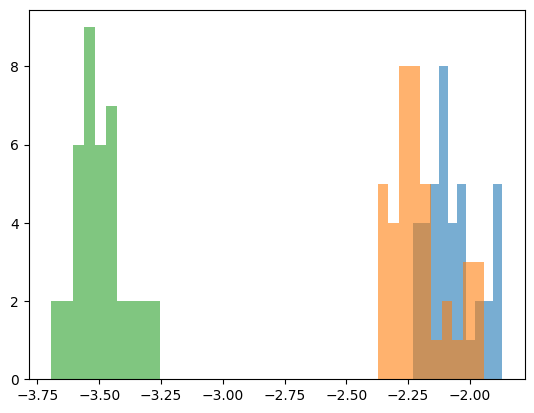

In [37]:
plt.hist(np.log10(keq_all[:, 0, 0]), bins=10, alpha=0.6)
plt.hist(np.log10(keq_all[:, 1, 1]), bins=10, alpha=0.6)
plt.hist(np.log10(keq_all[:, 2, 2]), bins=10, alpha=0.6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


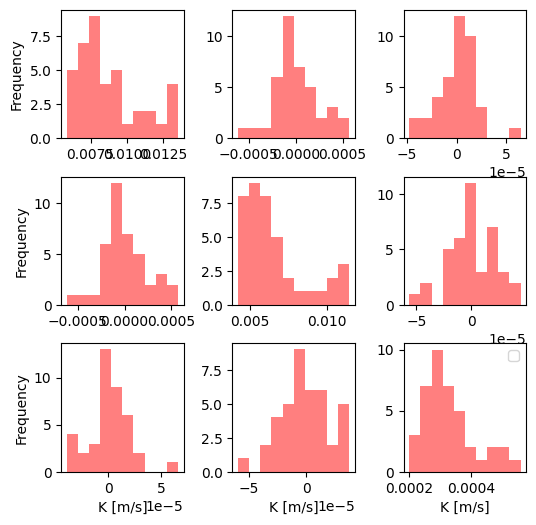

In [39]:
plt.figure(figsize=(6, 6), dpi=100)
plt.subplots_adjust(hspace=0.3, wspace=0.4)

for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3+j+1)
        plt.hist(keq_all[:, i, j], bins=10, alpha=0.5, color="red")
        
        if j == 0:
            plt.ylabel("Frequency")
        if i == 2:
            plt.xlabel("K [m/s]")
# plot legend on the last subplot
plt.legend()

In [57]:
K_eq = compute_k_eq(K)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package chd...
    loading package ic...
    loading package oc...
  loading solution package eros_eq_perm...
FloPy is using the following executable to run the model: ..\..\..\..\prog et code\modfow\exe\win64\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 19 2024 14:20:00 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and 

array([[-7.01410789e-03,  1.49095554e-04,  6.35725847e-05],
       [ 1.53869742e-04, -4.79571373e-03, -7.40974506e-05],
       [ 1.17582930e-05, -1.17852262e-05, -1.34263178e-03]])

In [58]:
K_eq = np.array([[-7.01410789e-03,  1.49095554e-04,  6.35725847e-05],
       [ 1.53869742e-04, -4.79571373e-03, -7.40974506e-05],
       [ 1.17582930e-05, -1.17852262e-05, -1.34263178e-03]])

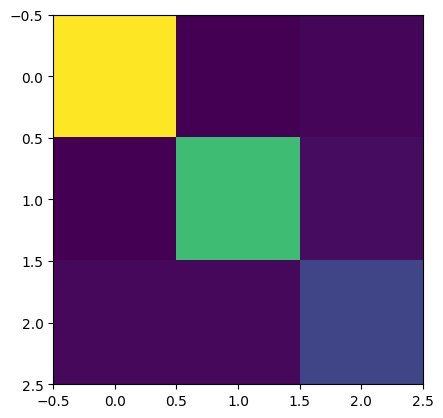

In [61]:
plt.imshow(-K_eq)

In [21]:
arr_plot = sims[0].copy().astype(float)
arr_plot[sims[0] == -99] = np.nan

In [22]:
p = pv.Plotter()

im=geone.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=arr_plot, varname="Units")
geone.imgplot3d.drawImage3D_surface(im, p, categCol=list(colors), categ=True)

x, y = np.meshgrid(xg, yg)

# for z in high_surfs[0]:
#     grid = pv.StructuredGrid(x, y, z)
#     p.add_mesh(grid)
p.show()

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\trame\ui\__init__.py:1: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame.ui')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pkg_resources\__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


Widget(value="<iframe src='http://localhost:62687/index.html?ui=P_0x2caef86b250_0&reconnect=auto' style='width…

In [37]:
pv.set_plot_theme("document")
ntbk = False

In [39]:
for i in range(3):
    
    arr_plot = sims[i].copy().astype(float)
    arr_plot[sims[i] == -99] = np.nan
    
    p = pv.Plotter(off_screen = True,notebook=ntbk)
    
    im=geone.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=arr_plot, varname="Units")
    geone.imgplot3d.drawImage3D_slice(im, p, categCol=list(colors), categ=True,
                                      slice_normal_x=(50, 120), slice_normal_y=(20, 80, 130), show_outline=False)

    # x, y = np.meshgrid(xg, yg)

    # for z in high_surfs[0]:
    #     grid = pv.StructuredGrid(x, y, z)
    #     p.add_mesh(grid, color="black")

    p.camera_position = 'yz'
    p.camera.azimuth = 45
    p.camera.elevation=20
    p.camera.zoom(1.2)

    p.remove_bounding_box()

    p.show(screenshot="200_Bumberg_3D_real{}.png".format(i))

In [35]:
z1

14

In [11]:
### bot - top

In [6]:
with open("NS_top.pkl", "rb") as f:
    top_ns = pickle.load(f)
    
with open("NS_bot.pkl", "rb") as f:
    bot_ns = pickle.load(f)
    
with open("EW_top.pkl", "rb") as f:
    top_ew = pickle.load(f)
    
with open("EW_bot.pkl", "rb") as f:
    bot_ew = pickle.load(f)

In [19]:
x1, top1 = top_ns
x2, top2 = top_ew

In [41]:
top_data = np.concatenate((top1, top2[::-1]))
x_data = np.concatenate((np.zeros([x1.shape[0]]), x2))
y_data = np.concatenate((x1, np.zeros([x2.shape[0]])))

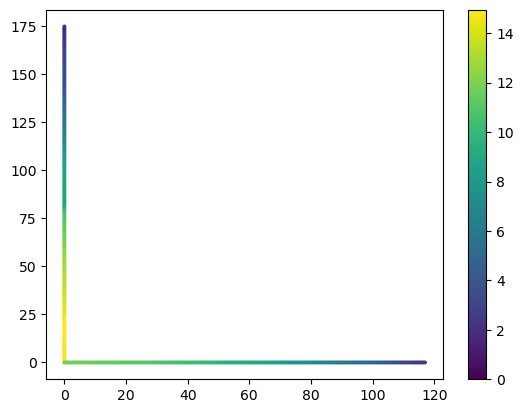

In [42]:
plt.scatter(x_data, y_data, c = top_data, vmin=0, s=3)
plt.colorbar()